In [1]:
# Para mas información, consulta el GitHub [https://github.com/Zygmut/Practica_3_IA]
# Autores: Palmer Pérez, Rubén; Torres Torres, Marc; Orr, Kieran Donal

# Setup
Importamos todos los paquetes necesarios para la práctica. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier 

Creamos un conjunto de variables para facil acceso y cambio de parámetros

In [3]:
TEST_SIZE = 0.33             # Proportion for test size in relation to the dataset
CORRELATION_THRESHOLD = 0.05 # Threshold to remove columns in the correlation matrix
ALTERNATIVE_MODE = False     # Quality (0-10) or ("bad", "average", "good")
QUALITY_THRESHOLD = 6        # Threshold that defines a range for each quality of wine ("bad", "average", "good")

Definimos una variable `DEBUG` (y su método de uso) que, en caso de estar activada, nos dará información adicional a lo largo de la ejecución del proyecto 

In [4]:
DEBUG = True 

def debugPrint(string):
    if DEBUG : print(f"[🐛] {string}")

# El dataset
Cargamos los datasets y les añadimos la columna `type` que nos permitara reconocer de que tipo son una vez juntados los datasets. Si `type = 0` el vino será blanco, de lo contrario sera rojo.

In [5]:
white = pd.read_csv("dataset/winequality-white.csv", sep=';')
white.insert(0, 'type', 0)
red = pd.read_csv("dataset/winequality-red.csv", sep= ';')
red.insert(0, 'type', 1)
df = pd.concat([white, red])
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Preparamos los datos del dataset eliminando todos los posibles valores nulos y transformando los valores que no sean `np.float64` o `np.int64` 

In [6]:
# Preparacion del dataset

labelencoder = LabelEncoder()

if not df[df.isna().any(axis=1)].shape[0] == 0 :
    debugPrint("Valores nulos eliminados para el dataframe")
    
df.dropna(inplace=True) # Eliminacion de valores nullos

for column in df.columns: # Transformar posibles valores no numericos
    if not df[column].dtype in (np.float64, np.int64):
        df[column] = labelencoder.fit_transform(df[column])
        debugPrint(f"Los valores de {column} se han transformado a numericos")


## Visualización de datos
En este apartado visualizaremos los datos para un entendimiento gráfico de nuestras carácteres.

Primero visualizaremos la disposición de nuestros datos con respecto a la **calidad**

<AxesSubplot:xlabel='quality', ylabel='count'>

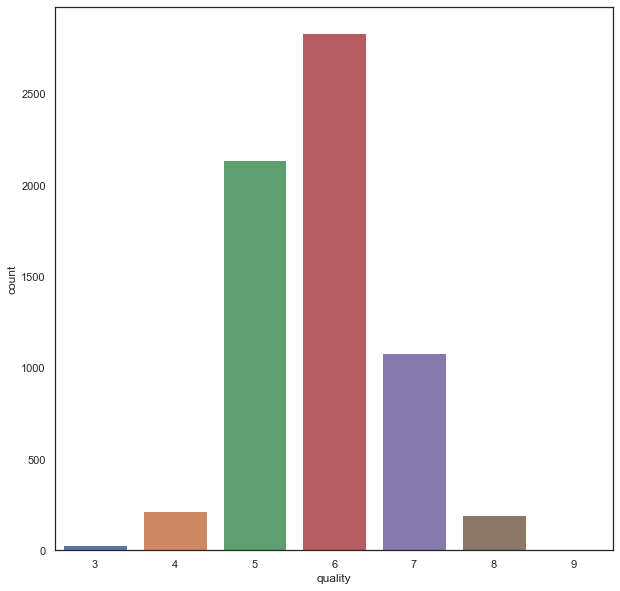

In [7]:
plt.figure(figsize=(10,10))
sns.set(style="white")
sns.countplot(x=df["quality"])

Como podemos ver aqui los datos estan distribuidos como una distribución normal, hay muchos datos por el centro en los valores de 5, 6 y 7 y pocos datos en los extremos. Eso es de esperar con una muestra de tamaño tan grande pero, el hecho de que haya tan pocos datos en los extremos nos va a causar problemas luego a la hora de hacer las predicciones sino categorizamos.  

Otra representación que puede ser interesante sería poder ver la diferencia de calidad entre los vinos tintos y los vinos blancos

<AxesSubplot:xlabel='quality', ylabel='count'>

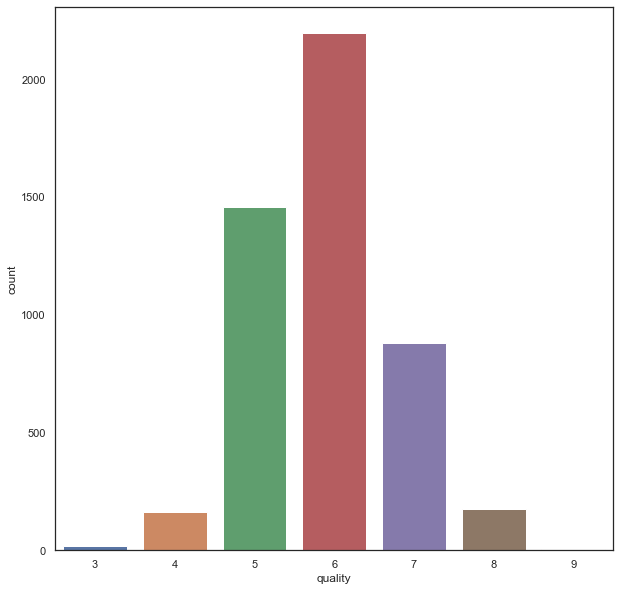

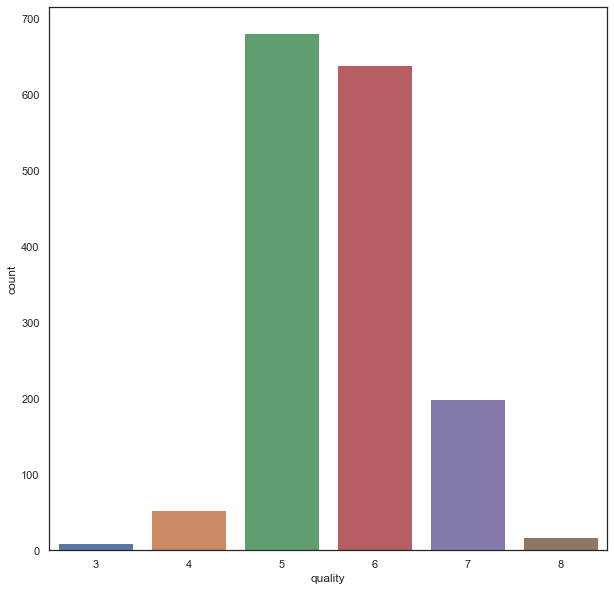

In [8]:
plt.figure(figsize=(10,10))
sns.set(style="white")
sns.countplot(x=white["quality"])

plt.figure(figsize=(10,10))
sns.set(style="white")
sns.countplot(x=red["quality"])

Podemos observar que, ademas de tener muchas mas muestras en el vino blanco, el vino tinto suele tener notas más bajas. Podemos calcular una media rápidamente para poder reasegurarlo.

In [9]:
print("Media de los vinos blancos: {}\t Media de los vinos tintos: {}".format(np.mean(white["quality"]), np.mean(red["quality"])))

Media de los vinos blancos: 5.87790935075541	 Media de los vinos tintos: 5.6360225140712945


Podemos tambien prinetar todos los posibles valores de las caracteristicas para tener una idea grafica de como es nuestro dataset completo

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>]], dtype=object)

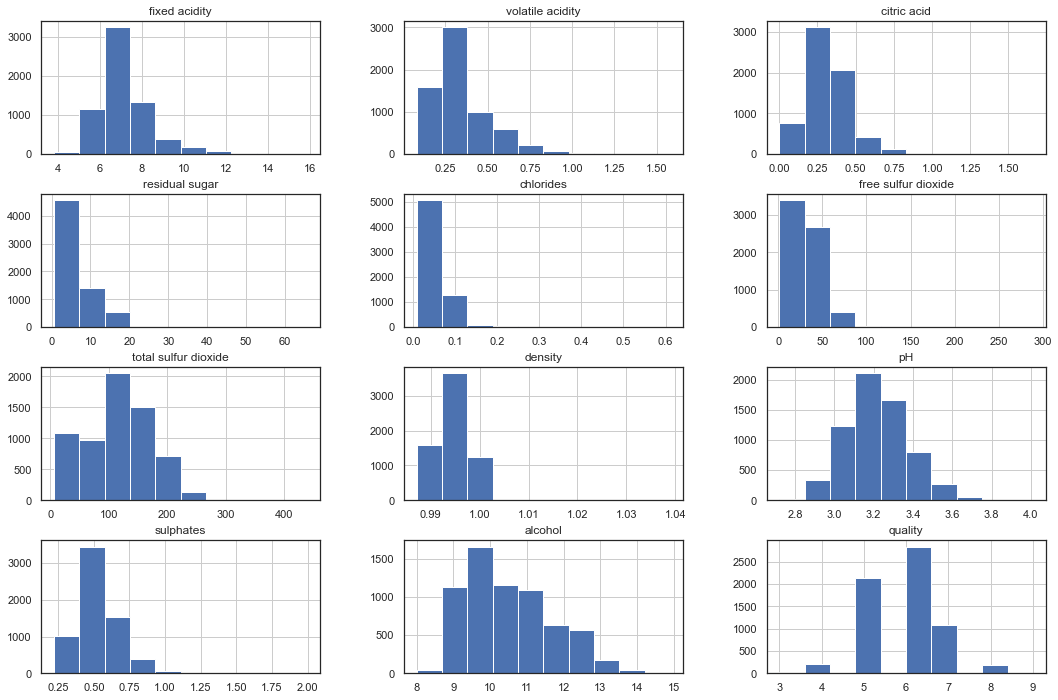

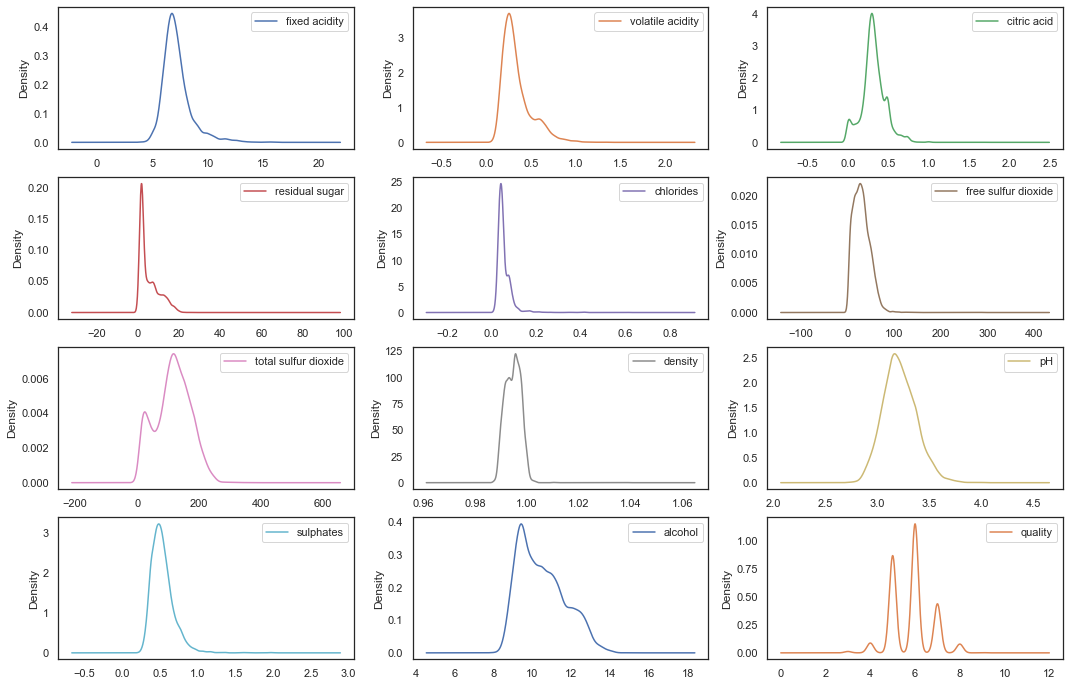

In [10]:
# Histogramas
df_show = df.drop("type", axis = 1)
df_show.hist(figsize=(18,12))

# Densidad de datos 
df_show.plot(kind='density', subplots = True, layout=(4,3), sharex=False, figsize=(18,12))

## Matriz de correlación
Como ya hemos visto en la visualización de los datos tenemos caracteristicas que, respecto a calidad, no nos ofrecen mucha variación. Para asegurarnos de esta independecia entre caracteristicas, analizaremos la matriz de correlación. Tenemos una variable llamada `CORRELATION_THRESHOLD` que define la desviación mínima que aceptamos. Es decir, si tenemos una correlación de `0.03` con respecto a _quality_, podemos decir que son suficientemente independientes como para no tenerlas en cuenta. De esta manera, podemos reducir el tamaños de las caracteristicas para el entrenamiento de nuestro modelos

[🐛] Removed column 4
[🐛] Removed column 7
[🐛] Removed column 9
[🐛] Removed column 10


<AxesSubplot:>

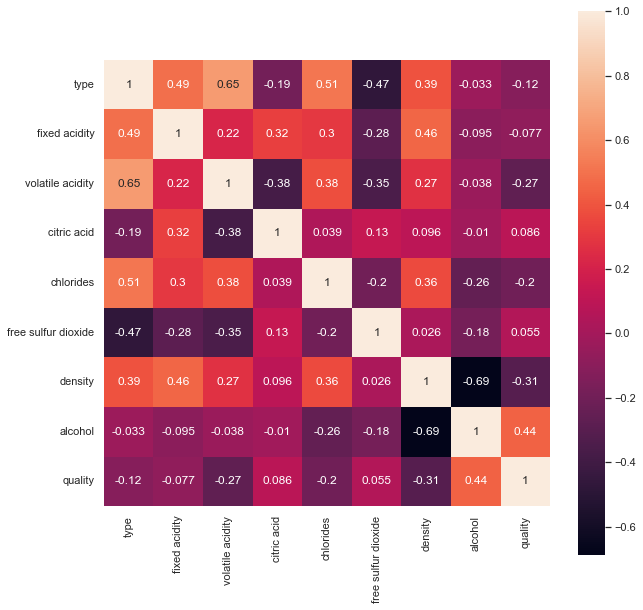

In [11]:
fig = plt.figure(figsize=(10,10))

removed_columns = []

for i in range(len(df.corr()["quality"])):
    if abs(df.corr()["quality"][i]) < CORRELATION_THRESHOLD:
        debugPrint(f"Removed column {i}") 
        removed_columns.append(i)
        

df.drop(df.columns[removed_columns], axis=1, inplace = True)
  
sns.heatmap(df.corr(), annot=True, square=True)


Adicionalmente, definiremos unos rangos de calidad de tal manera que :
- baja &rarr; "quality" < `QUALITY_THRESHOLD` 
- media &rarr; "quality" = `QUALITY_THRESHOLD` 
- alta &rarr; "quality" > `QUALITY_THRESHOLD` 

Lo tomaremos tal que:
- baja &rarr; 1 
- media &rarr; 2
- alta &rarr; 3

In [12]:
if ALTERNATIVE_MODE :
    debugPrint("Alternative mode detected")
    df["quality"] = df["quality"].apply(lambda y: 1 if y<QUALITY_THRESHOLD else y)
    df["quality"] = df["quality"].apply(lambda y: 2 if y==QUALITY_THRESHOLD else y)
    df["quality"] = df["quality"].apply(lambda y: 3 if y>QUALITY_THRESHOLD else y)

debugPrint(df["quality"].unique())

[🐛] [6 5 7 8 4 3 9]


Poder juntar las puntuaciones en categorias nos ayudara mucho a la hora de hacer predicciones ya que puntuaciones como el 9 tiene solo 5 ejemplos, hacer predicciones con una muestra tan pequeña resulta ser difícil. Pero si los juntamos con lo 8 y 7 nos da mas data para hacer tests.

## Escalado de datos
Por último, escalamos los datos y separamos las "features" y etiquetas

In [13]:
m_M_scaler = preprocessing.MinMaxScaler()

# Separamos las features de las etiquetas 
y = df["quality"]
x = df.drop("quality", axis=1)

# Escalamos los datos
x = m_M_scaler.fit_transform(x)


### Separación del conjunto de entrenamiento, validación y testeo
Una vez obtenido nuestro dataset con sus valores procesados, creamos los 2 subconjuntos de datos que nos permitirán entrenar nuestros modelos (entrenamiento y testeo). El subconjutno de validación se creará posteriormente.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=TEST_SIZE, stratify=y , random_state=42)

# Modelos
Una vez preparado nuestros datasets de entrenamiento y testeo, podemos usarlos para nuestros modelos de machine learning

In [15]:
# Definimos las etiquetas
targetType = ["bad", "average", "good"]

## Aplicación

Podemos observar que para la solución cuya salida es una nota tenemos varias `zero_division`. Esto ocurre debido a una desproporción de datos. Esto se podría solucionar si tuviesemos más datos para todas las posibles calidades de nuestro dataset. Para esta solución, en vez de generar datos a partir de los actuales mediante algún tipo de interpolación, trataremos estas `zero_division` como 1 

### Regresión logística
Debemos aumentar las `max_iter` ya que el número de iteraciónes base (100) no es suficiente

In [16]:
clr = LogisticRegression(random_state=0, max_iter=200).fit(x_train, y_train) # Aumentamos las iteraciónes 
y_hat = clr.predict(x_test)

if ALTERNATIVE_MODE:
    print(classification_report(y_test, y_hat, target_names=targetType))
else: 
    print(classification_report(y_test, y_hat, zero_division=1)) # Evitamos el error de "división por zero" 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00        10
           4       1.00      0.00      0.00        71
           5       0.57      0.61      0.59       706
           6       0.51      0.69      0.59       936
           7       0.42      0.14      0.21       356
           8       1.00      0.00      0.00        64
           9       1.00      0.00      0.00         2

    accuracy                           0.53      2145
   macro avg       0.79      0.21      0.20      2145
weighted avg       0.55      0.53      0.49      2145



### Perceptron

In [17]:
cp = Perceptron(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)

if ALTERNATIVE_MODE:
    print(classification_report(y_test, y_hat, target_names=targetType))
else: 
    print(classification_report(y_test, y_hat, zero_division=1)) # Evitamos el error de "división por zero" 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00        10
           4       0.29      0.10      0.15        71
           5       0.58      0.28      0.38       706
           6       0.46      0.88      0.61       936
           7       1.00      0.00      0.00       356
           8       1.00      0.00      0.00        64
           9       1.00      0.00      0.00         2

    accuracy                           0.48      2145
   macro avg       0.76      0.18      0.16      2145
weighted avg       0.61      0.48      0.40      2145



### Random forest

In [18]:
crf = RandomForestClassifier(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)

if ALTERNATIVE_MODE:
    print(classification_report(y_test, y_hat, target_names=targetType))
else: 
    print(classification_report(y_test, y_hat, zero_division=1)) # Evitamos el error de "división por zero" 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00        10
           4       0.29      0.10      0.15        71
           5       0.58      0.28      0.38       706
           6       0.46      0.88      0.61       936
           7       1.00      0.00      0.00       356
           8       1.00      0.00      0.00        64
           9       1.00      0.00      0.00         2

    accuracy                           0.48      2145
   macro avg       0.76      0.18      0.16      2145
weighted avg       0.61      0.48      0.40      2145



## Analisis de los resultados